CNN → Concat　による画像での４ラベル診断比較

In [1]:
import os
from torch.utils.data import DataLoader
from dataloader_asc import create_dataset_12_asc
import matplotlib.pyplot as plt
from PIL import ImageOps
import torchvision
import numpy as np
import cv2

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import *


device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)
path = os.getcwd()
path = '/root/notebooks/sample/dataset/img_4label'
train_dataloader,test_dataloader,label_lead, labels=create_dataset_12_asc(path,1,None)

/python/build/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:1
Classification lab : {'Lateral': 0, 'Posterior': 1, 'Anterior': 2, 'Inferior': 3}
Number of datas 198
イメージ形
torch.Size([12, 198, 3, 112, 224])
198
198


In [2]:
class ReshapeLayer(nn.Module):
    def __init__(self, target_shape):
        super(ReshapeLayer, self).__init__()
        self.target_shape = target_shape

    def forward(self, x):
        return x.view(*self.target_shape)
    
# モデルクラス
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # 畳み込み層や全結合層などを定義する
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.faltten = nn.Flatten()
        
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.gap(x)
        x = self.faltten(x)
        return x

# モデルのインスタンスを作成
model1 = CNNModel().to(device)


model = nn.Sequential(
    model1,
    ReshapeLayer((1,384)),
    nn.Linear(384, 128),
    nn.Linear(128, 32)
)

model = model.to(device)


In [3]:
test = torch.randn(12, 3, 112, 224)

In [4]:
# 損失関数
criterion = nn.CrossEntropyLoss()


# 最適化アルゴリズム
optimizer = optim.Adam(model.parameters(), lr=0.0001)
bestscore_np = 1000.0
loss_list_np,loss_list_test_np = [], []
f1s_np, f1s_test_np = [],[]
acc_np, acc_test_np = [], []

num_epochs_np = 200

# モデル訓練　5クラス分類

for epoch in range(num_epochs_np):
    model.train()
    running_loss_np = 0.0
    preds_np, label_np = [], []
    running_loss_np, running_loss_test_np = 0.0, 0.0
    preds_test_np,label_test_np = [], []

    for ecg_image, labels, label_lead, patients, num_leads in train_dataloader:
        image = ecg_image.reshape(-1, 3, 112, 224).to(device)
        labels = labels.reshape(-1).to(device)  # ラベルを1次元に変形
        labels = labels.to(torch.long)  # CrossEntropyLossではクラスのインデックスはlong型である必要がある

        optimizer.zero_grad()  # 勾配を初期化

        outputs = model(image).to(torch.float64)  # モデルの出力を計算

        prob, pred = torch.max(outputs, 1)
        preds_np.extend(pred.tolist())
        label_np.extend(labels.tolist())

        loss = criterion(outputs, labels)  # 損失を計算（CrossEntropyLossの引数は予測とラベル）
        loss.backward()  # 勾配を計算
        optimizer.step()  # パラメータを更新

        running_loss_np += loss.item()

    for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
        image =ecg_image.reshape(-1,3,112,224).to(device)
        labels = labels.reshape(-1).to(device)

        outputs = model(image)  # モデルの出力を計算
        outputs = outputs.to(torch.float64)
        prob, pred=torch.max(outputs,1)
        preds_test_np.extend(pred.tolist())
        label_test_np.extend(labels.tolist())
        
        #print(outputs)
        loss = criterion(outputs, labels)  # 損失を計算

        running_loss_test_np += loss.item()
    
    score_np = running_loss_test_np/len(test_dataloader)

    loss_list_np.append(running_loss_np/len(train_dataloader))
    loss_list_test_np.append(running_loss_test_np/len(test_dataloader))
    f1_np = f1_score(preds_np,label_np,average='macro')
    f1_test_np = f1_score(preds_test_np,label_test_np,average='macro')
    f1s_np.append(f1_np)
    f1s_test_np.append(f1_test_np)
    accuracy_np = accuracy_score(preds_np,label_np)
    accuracy_test_np = accuracy_score(preds_test_np,label_test_np)
    acc_np.append(accuracy_np)
    acc_test_np.append(accuracy_test_np)

    if score_np < bestscore_np:
        bestscore_np = score_np
        torch.save(model.state_dict(), '/root/notebooks/sample/models/bestmodel_img.pth')
        print('best score_np!!')
        bestf1_np = f1_test_np
        bestacc_np = accuracy_test_np
        
    # 1エポック終了時の損失を表示
    print(f"Epoch [{epoch+1}/{num_epochs_np}] Train-Loss: {running_loss_np/len(train_dataloader)} Test-Loss: {running_loss_test_np/len(train_dataloader)} Train-f1: {f1_np} Test-f1: {f1_test_np} Train-acc: {accuracy_np} Test-acc: {accuracy_test_np}")

print('bestf1', bestf1_np)
print('bestacc', bestacc_np)

best score_np!!
Epoch [1/200] Train-Loss: 2.351236917189489 Test-Loss: 0.30999701058376283 Train-f1: 0.15193207416392304 Test-f1: 0.15517241379310345 Train-acc: 0.4050632911392405 Test-acc: 0.45
best score_np!!
Epoch [2/200] Train-Loss: 1.157354692763704 Test-Loss: 0.2885910002985285 Train-f1: 0.2196319018404908 Test-f1: 0.15517241379310345 Train-acc: 0.41139240506329117 Test-acc: 0.45
best score_np!!
Epoch [3/200] Train-Loss: 1.1427986619222739 Test-Loss: 0.27869358532139177 Train-f1: 0.17884709330727896 Test-f1: 0.15517241379310345 Train-acc: 0.35443037974683544 Test-acc: 0.45
best score_np!!
Epoch [4/200] Train-Loss: 1.1085150993128619 Test-Loss: 0.2758080558536076 Train-f1: 0.21368371212121212 Test-f1: 0.15517241379310345 Train-acc: 0.3987341772151899 Test-acc: 0.45
Epoch [5/200] Train-Loss: 1.1001521620993935 Test-Loss: 0.2774832452025361 Train-f1: 0.22979318850203964 Test-f1: 0.14285714285714288 Train-acc: 0.43037974683544306 Test-acc: 0.4
best score_np!!
Epoch [6/200] Train-Loss

In [5]:
# モデル評価 ５クラス診断(事前学習なし)
pred_np,label_np = [],[]
model.load_state_dict(torch.load('/root/notebooks/sample/models/bestmodel_img.pth'))
model.eval()

for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
    image =ecg_image.reshape(-1,3,112,224).to(device)
    labels = labels.reshape(-1).to(device)
    label_np.extend(labels.tolist())
    outputs = model(image)  # モデルの出力を計算
    prob_np, preds_np=torch.max(outputs,1)
    pred_np.extend(preds_np.tolist())
    f1_test_np = f1_score(preds_np.tolist(),labels.tolist(),average='macro')
    accuracy_test_np = accuracy_score(preds_test_np,label_test_np)
    loss = criterion(outputs, labels)  # 損失を計算

    running_loss_test_np += loss.item()

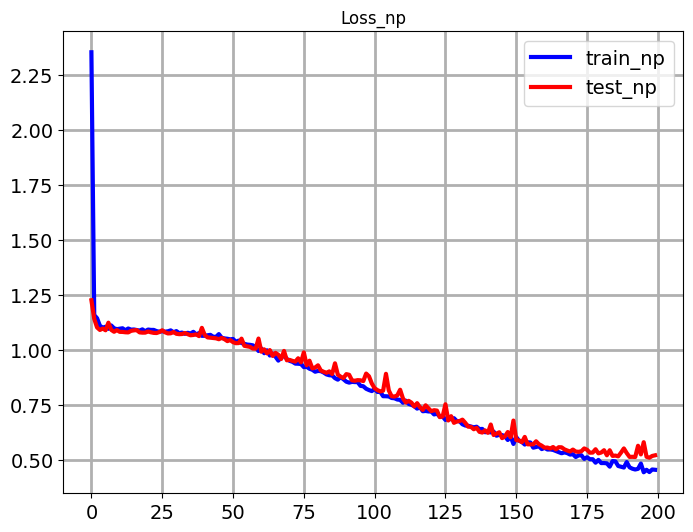

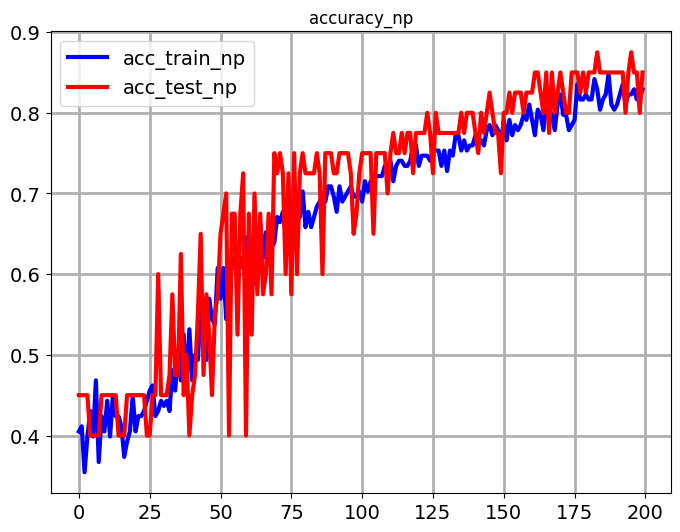

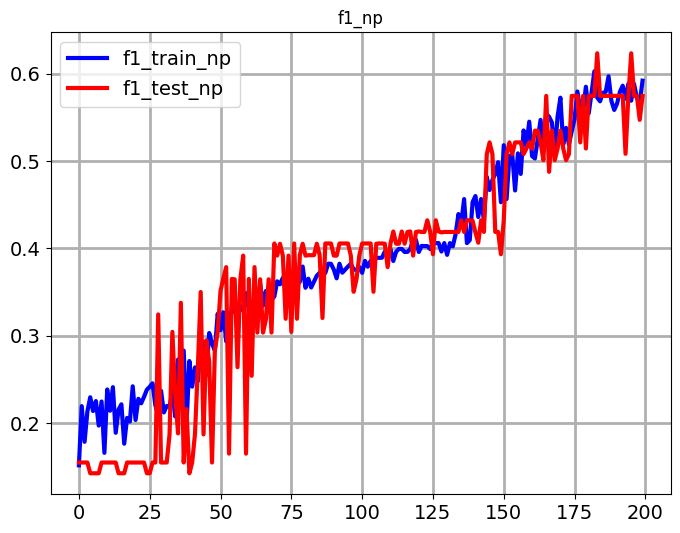

In [6]:
# 学習曲線 (損失関数) 事前学習
plt.figure(figsize=(8,6))
plt.plot(loss_list_np,label='train_np', lw=3, c='b')
plt.plot(loss_list_test_np,label='test_np', lw=3, c='r')
plt.title('Loss_np')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

# 学習曲線 (accuracy)
plt.figure(figsize=(8,6))
plt.plot(acc_np,label='acc_train_np', lw=3, c='b')
plt.plot(acc_test_np,label='acc_test_np', lw=3, c='r')
plt.title('accuracy_np')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

# 学習曲線 (F1)
plt.figure(figsize=(8,6))
plt.plot(f1s_np,label='f1_train_np', lw=3, c='b')
plt.plot(f1s_test_np,label='f1_test_np', lw=3, c='r')
plt.title('f1_np')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()


Confusion matrix, without normalization
[[ 0  0  1  0]
 [ 0  2  1  2]
 [ 0  0 18  0]
 [ 0  1  1 14]]


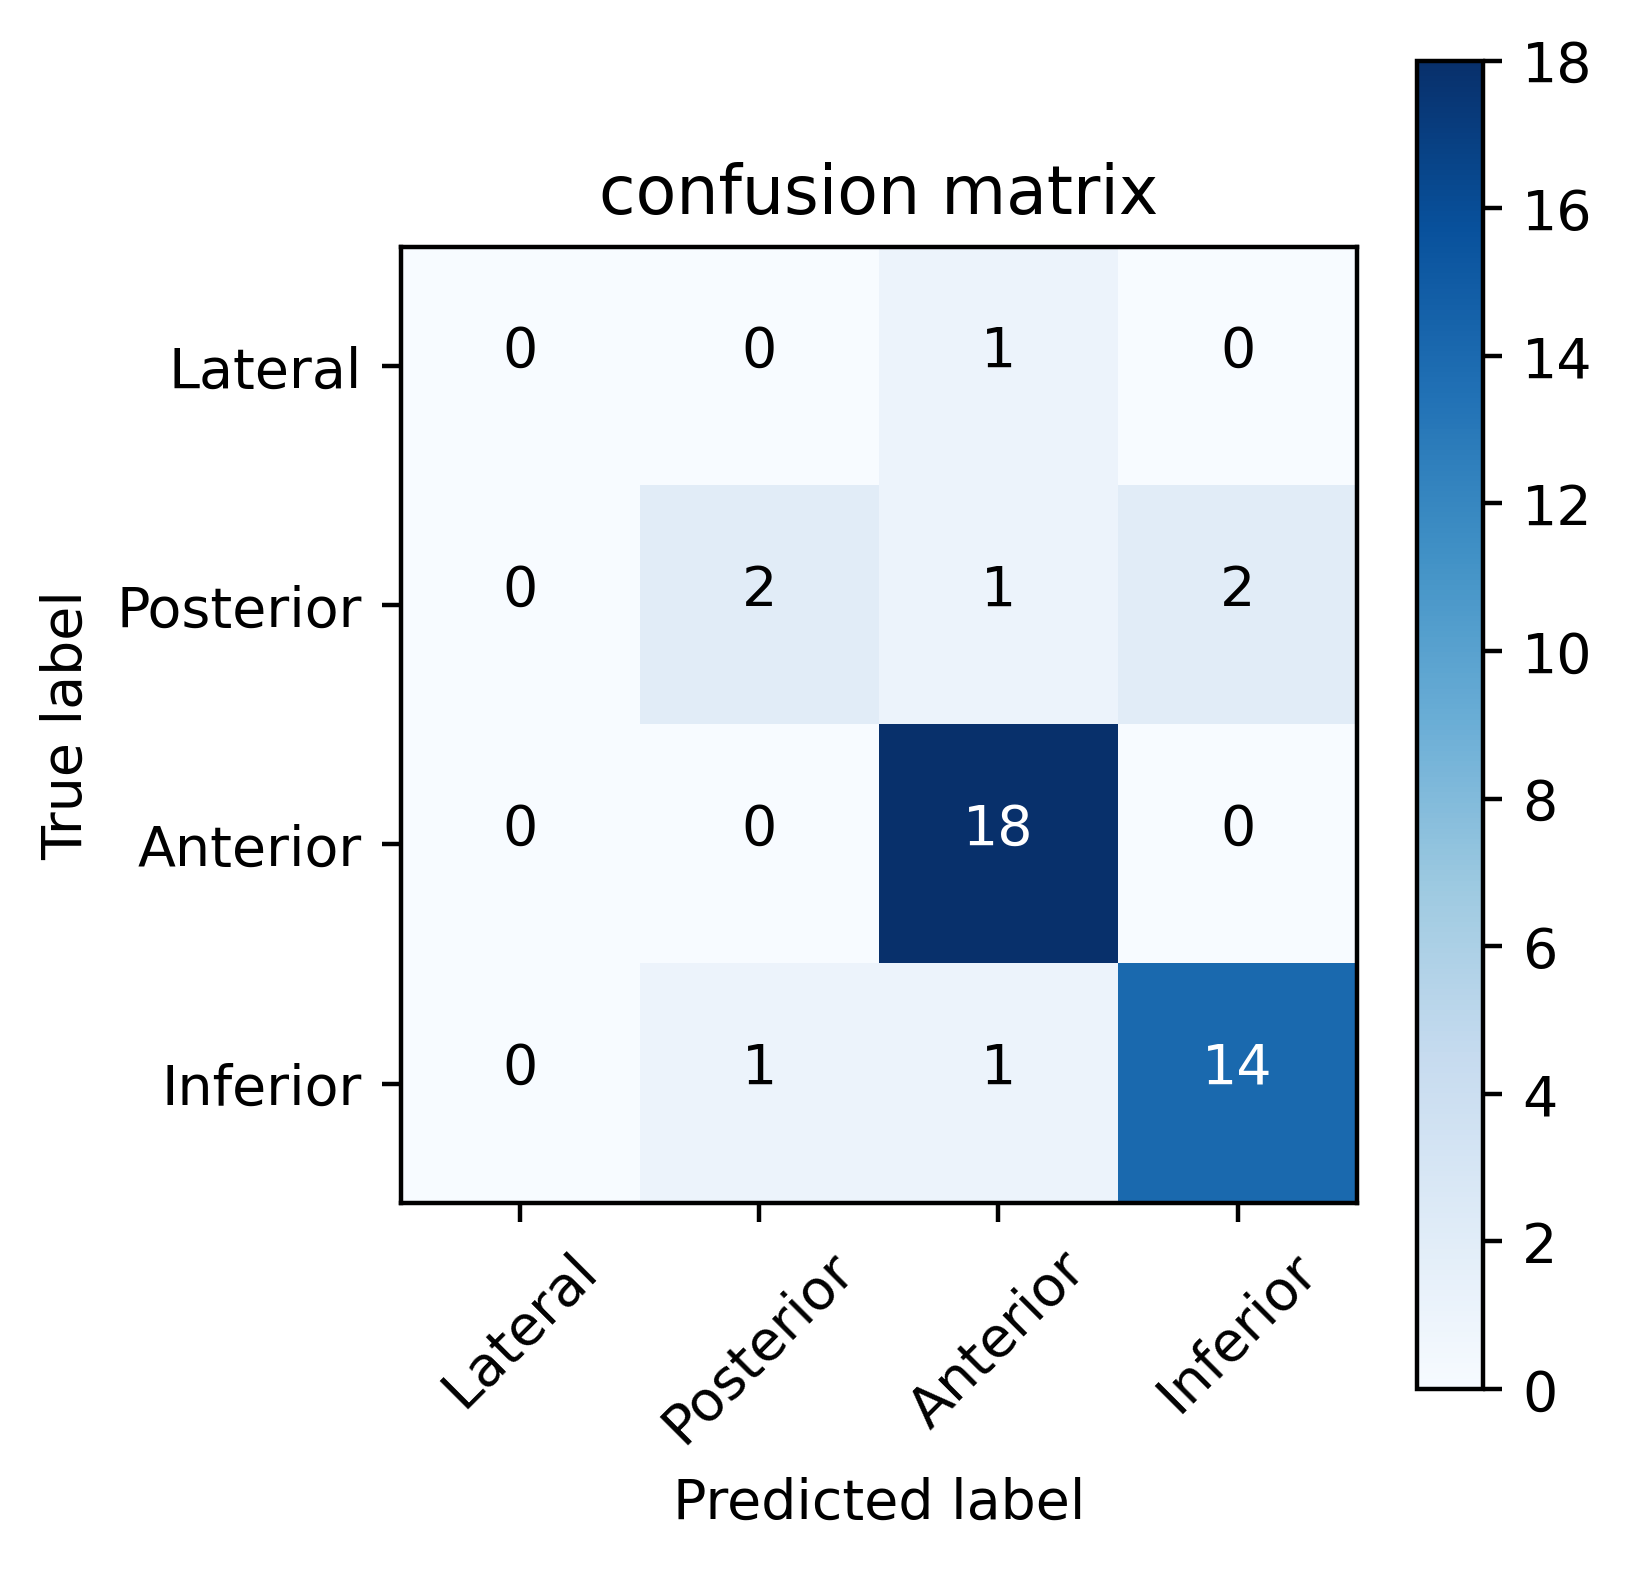

In [7]:
# Confusion matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
           """
           This function prints and plots the confusion matrix.
           Normalization can be applied by setting `normalize=True`.
           """
           if normalize:
               cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
               print("Normalized confusion matrix")
           else:
               print('Confusion matrix, without normalization')
           print(cm)
           plt.imshow(cm, interpolation='nearest', cmap=cmap)
           plt.title(title)
           plt.colorbar()
           tick_marks = np.arange(len(classes))
           plt.xticks(tick_marks, classes, rotation=45)
           plt.yticks(tick_marks, classes)
           fmt = '.2f' if normalize else 'd'
           thresh = cm.max() / 2.
           for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
               plt.text(j, i, format(cm[i, j], fmt),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")
           plt.tight_layout()
           plt.ylabel('True label')
           plt.xlabel('Predicted label')
           #plt.savefig(output_file)

labels_np=[0,1,2,3]
label2_np=['Lateral','Posterior', 'Anterior', 'Inferior', ]
cnf_matrix=confusion_matrix(label_np,pred_np,labels=labels_np)
title="confusion matrix"
plt.figure(figsize=(4,4),dpi=400)
plot_confusion_matrix(cnf_matrix, classes=label2_np,title=title)
plt.show()